In [ ]:
!pip install ultralytics roboflow fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.2 MB/s eta 0:00:00
  

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Ce4WN2N0FDuYAXhS7WJk")
project = rf.workspace("football-ai-c6sra").project("jr-nba-hsequ")
version = project.version(2)
dataset = version.download("coco")

DATASET_DIR = dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Jr.-NBA-2 in coco:: 100%|██████████| 24/24 [00:00<00:00, 2826.51it/s]


In [ ]:
print("Dataset dir:", DATASET_DIR)

Dataset dir: /content/Jr.-NBA-2


In [ ]:
"""
Complete YOLOv8 training script (Python)

How to use:
1. Prepare your dataset in YOLO format (images + .txt annotations) or use Roboflow to export to YOLOv8 format.
   Dataset layout expected by this script:
     /path/to/dataset/
       images/
         train/
         val/
       labels/
         train/
         val/

2. Edit the `CONFIG` dictionary below to point to your dataset and settings.
3. Run: python yolov8_train_script.py

This script uses the Ultralytics YOLO Python API.
Install: pip install ultralytics

"""

import os
import yaml
import argparse
from pathlib import Path

# Attempt to import ultralytics; give user-friendly message if missing
try:
    from ultralytics import YOLO
except Exception as e:
    raise ImportError(
        "The ultralytics package is required. Install with: pip install ultralytics"
    ) from e

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os

print("ROOT:", DATASET_DIR)
print("----")

for split in ["train", "valid", "test"]:
    split_path = f"{DATASET_DIR}/{split}"
    print(f"\n{split} folder exists:", os.path.exists(split_path))

    if os.path.exists(split_path):
        print("Contents:", os.listdir(split_path))


ROOT: /content/Jr.-NBA-2
----

train folder exists: True
Contents: ['labels', '_annotations.coco.json', 'images', 'labels.cache']

valid folder exists: True
Contents: ['labels', '_annotations.coco.json', 'images', 'labels.cache']

test folder exists: True
Contents: ['labels', '_annotations.coco.json', 'images']


In [ ]:
import os
import json
import shutil
import yaml

# ------------------------------------------------------------
# 1. Ensure YOLO folder structure
# ------------------------------------------------------------
for split in ["train", "valid", "test"]:
    os.makedirs(f"{DATASET_DIR}/{split}/images", exist_ok=True)
    os.makedirs(f"{DATASET_DIR}/{split}/labels", exist_ok=True)


# ------------------------------------------------------------
# 2. Function to convert COCO → YOLO label format
# ------------------------------------------------------------

def convert_coco_to_yolo(json_path, split):
    print(f"\n🔄 Converting {split} annotations from COCO → YOLO")

    with open(json_path, "r") as f:
        data = json.load(f)

    images = {img["id"]: img["file_name"] for img in data["images"]}

    # category ID mapping
    cat_map = {cat["id"]: idx for idx, cat in enumerate(data["categories"])}

    labels_dir = f"{DATASET_DIR}/{split}/labels"
    images_dir = f"{DATASET_DIR}/{split}/images"

    for ann in data["annotations"]:
        img_id = ann["image_id"]
        file_name = images[img_id]

        # move image into 'images' folder
        src_img = f"{DATASET_DIR}/{split}/{file_name}"
        dst_img = f"{images_dir}/{file_name}"
        if os.path.exists(src_img):
            shutil.move(src_img, dst_img)

        # COCO box → YOLO box
        x, y, w, h = ann["bbox"]
        img_info = next(img for img in data["images"] if img["id"] == img_id)
        img_w = img_info["width"]
        img_h = img_info["height"]

        # YOLO format
        xc = (x + w / 2) / img_w
        yc = (y + h / 2) / img_h
        nw = w / img_w
        nh = h / img_h

        class_id = cat_map[ann["category_id"]]

        txt_file = f"{labels_dir}/{file_name.replace('.jpg', '').replace('.png', '')}.txt"

        with open(txt_file, "a") as f:
            f.write(f"{class_id} {xc} {yc} {nw} {nh}\n")

    print(f"✅ Done: YOLO labels created for {split}")


# ------------------------------------------------------------
# 3. Run conversion for each split
# ------------------------------------------------------------

for split in ["train", "valid", "test"]:
    json_file = f"{DATASET_DIR}/{split}/_annotations.coco.json"
    if os.path.exists(json_file):
        convert_coco_to_yolo(json_file, split)
    else:
        print(f"⚠️ No COCO file found for {split}")

# ------------------------------------------------------------
# 4. Create data.yaml
# ------------------------------------------------------------

yaml_path = os.path.join(DATASET_DIR, "data.yaml")

data_yaml = {
    "train": f"{DATASET_DIR}/train/images",
    "val": f"{DATASET_DIR}/valid/images",
    "test": f"{DATASET_DIR}/test/images",
    "nc": len(json.load(open(f"{DATASET_DIR}/train/_annotations.coco.json"))["categories"]),
    "names": [cat["name"] for cat in json.load(open(f"{DATASET_DIR}/train/_annotations.coco.json"))["categories"]]
}

with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f)

print("\n🎉 data.yaml created!")
print("Contents:")
print(yaml.dump(data_yaml))



🔄 Converting train annotations from COCO → YOLO
✅ Done: YOLO labels created for train

🔄 Converting valid annotations from COCO → YOLO
✅ Done: YOLO labels created for valid

🔄 Converting test annotations from COCO → YOLO
✅ Done: YOLO labels created for test

🎉 data.yaml created!
Contents:
names:
- symbols
- Filled Circle
- Hollow Circle
- Slash
nc: 4
test: /content/Jr.-NBA-2/test/images
train: /content/Jr.-NBA-2/train/images
val: /content/Jr.-NBA-2/valid/images



In [ ]:
from ultralytics import YOLO

def train_yolo(
    dataset_dir,
    epochs=20,
    batch_size=4,
    imgsz=640,
    lr=1e-3,
    device=0,
    output_dir="yolo_out",
    model_name="yolov8n.pt"
):
    """
    Simple training wrapper for YOLO — mirrors the style of your RFDETR training code.

    Args:
        dataset_dir: Directory containing images/ & labels/ in YOLO format
        epochs: Number of epochs
        batch_size: Batch size for training
        imgsz: Input image resolution
        lr: Learning rate
        device: GPU id or 'cpu'
        output_dir: Where results will be saved
        model_name: YOLO model weights (yolov8n.pt, yolov8s.pt, etc.)
    """

    # 1. Load YOLO model (pretrained)
    model = YOLO(model_name)

    # 2. Training
    results = model.train(
        data=f"{dataset_dir}/data.yaml",  # YAML created by Roboflow
        epochs=epochs,
        batch=batch_size,
        imgsz=imgsz,
        lr0=lr,            # YOLO’s base LR argument
        device=device,
        project=output_dir,
        name="train_run",
        exist_ok=True
    )

    print("Training complete!")
    return results


In [ ]:
print("Dataset dir:", DATASET_DIR)

Dataset dir: /content/Jr.-NBA-2


In [ ]:
train_yolo(
    dataset_dir=DATASET_DIR,  # same var you used with RFDETR
    epochs=20,
    batch_size=4,
    imgsz=640,
    lr=1e-3,
    device="cpu",      # ← IMPORTANT
    output_dir="yolo_out",
    model_name="yolov8n.pt"
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Jr.-NBA-2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b17f198a5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo_out/train_run/weights/best.pt")  # path to your best model

metrics = model.val(
    data="/content/Jr.-NBA-2/data.yaml",
    imgsz=640
)

print(metrics)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1167.8±368.6 MB/s, size: 43.9 KB)
val: Scanning /content/Jr.-NBA-2/valid/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2/2 1.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.7it/s 0.6s
                   all          2         63     0.0398      0.228      0.194       0.07
         Filled Circle          2         19      0.119      0.684      0.583       0.21
         Hollow Circle          2         15          0          0          0          0
                 Slash          2         29          0          0          0          0
Speed: 1.9ms preprocess, 267.6ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.util

In [ ]:
results = model.val(data="/content/Jr.-NBA-2/data.yaml")

print("mAP50:", results.box.map50)
print("mAP50-95:", results.box.map)
print("Precision:", results.box.mp)
print("Recall:", results.box.mr)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 619.8±150.0 MB/s, size: 43.9 KB)
val: Scanning /content/Jr.-NBA-2/valid/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2/2 1.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.0it/s 1.0s
                   all          2         63     0.0398      0.228      0.194       0.07
         Filled Circle          2         19      0.119      0.684      0.583       0.21
         Hollow Circle          2         15          0          0          0          0
                 Slash          2         29          0          0          0          0
Speed: 1.9ms preprocess, 457.4ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /content/runs/detect/val3
mAP50: 0.19420027146805344
mAP50-95: 0.07001460492208117
Precision: 0.039755351681957186
Recall:

In [ ]:
import os

val_dir = "/content/Jr.-NBA-2/valid/images"
images = os.listdir(val_dir)

# filter only image files
images = [img for img in images if img.lower().endswith((".jpg", ".jpeg", ".png"))]

print("Found images:", images)

img_path = os.path.join(val_dir, images[0])  # first image
print("Using:", img_path)


Found images: ['WhatsApp-Image-2025-11-15-at-21_40_27_jpeg.rf.669c8f767c230bcfc4134973bb4b3137.jpg', 'IMG_20251115_205326_jpg.rf.0b096a79173b13f7376c8915ff58b02e.jpg']
Using: /content/Jr.-NBA-2/valid/images/WhatsApp-Image-2025-11-15-at-21_40_27_jpeg.rf.669c8f767c230bcfc4134973bb4b3137.jpg



image 1/1 /content/Jr.-NBA-2/valid/images/WhatsApp-Image-2025-11-15-at-21_40_27_jpeg.rf.669c8f767c230bcfc4134973bb4b3137.jpg: 640x640 (no detections), 1212.3ms
Speed: 8.8ms preprocess, 1212.3ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)


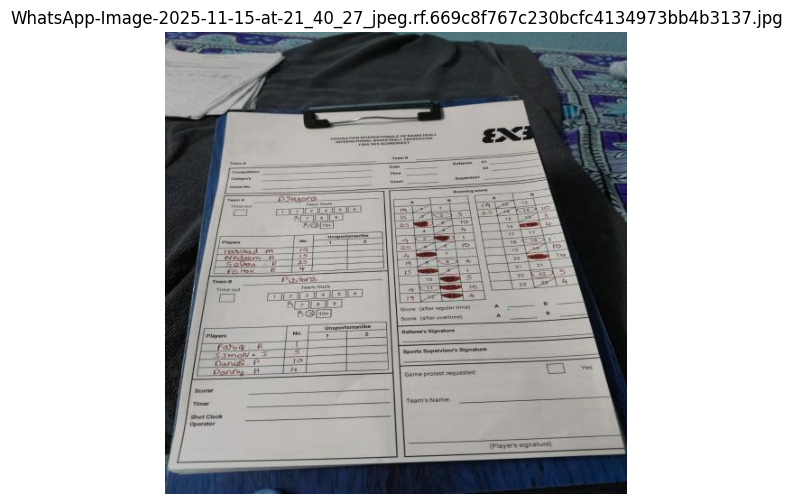


image 1/1 /content/Jr.-NBA-2/valid/images/IMG_20251115_205326_jpg.rf.0b096a79173b13f7376c8915ff58b02e.jpg: 640x640 (no detections), 889.3ms
Speed: 9.7ms preprocess, 889.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


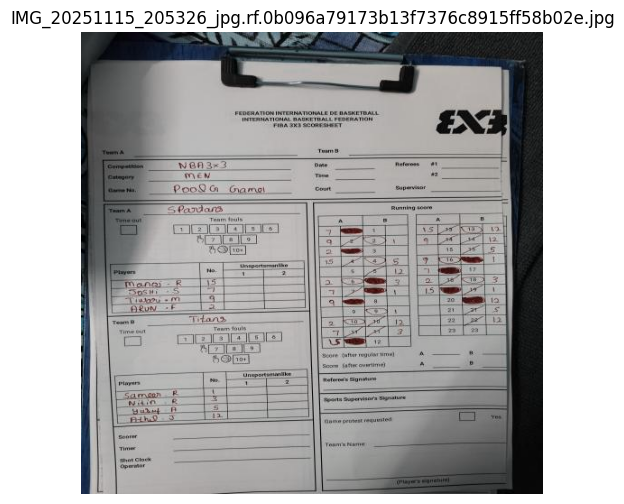

In [ ]:
import os
import matplotlib.pyplot as plt

val_dir = "/content/Jr.-NBA-2/valid/images"
images = [f for f in os.listdir(val_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

for img in images:
    img_path = os.path.join(val_dir, img)
    results = model(img_path)

    plt.figure(figsize=(6,6))
    plt.imshow(results[0].plot())
    plt.title(img)
    plt.axis("off")
    plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("yolo_out/train_run/results.csv")
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,12.6496,4.14885,5.37599,1.71670,0.00000,0.00000,0.00000,0.00000,3.05930,4.54781,1.33248,0.000025,0.000025,0.000025
1,2,24.1492,3.14226,4.55475,1.45900,0.00000,0.00000,0.00000,0.00000,2.86925,4.49594,1.25713,0.000059,0.000059,0.000059
2,3,35.9977,3.58798,4.52166,1.39229,0.00000,0.00000,0.00000,0.00000,2.71379,4.47984,1.20459,0.000090,0.000090,0.000090
3,4,47.7781,2.95145,4.40152,1.29416,0.00000,0.00000,0.00000,0.00000,2.59069,4.46516,1.16040,0.000117,0.000117,0.000117
4,5,59.4258,2.79841,4.28577,1.19774,0.00000,0.00000,0.00000,0.00000,2.57591,4.44920,1.13060,0.000140,0.000140,0.000140
5,6,71.0409,2.66238,4.12115,1.19257,0.00000,0.00000,0.00000,0.00000,2.52519,4.43260,1.10759,0.000160,0.000160,0.000160
6,7,84.1821,2.80453,4.14671,1.20511,0.00000,0.00000,0.00000,0.00000,2.45150,4.35734,1.08941,0.000176,0.000176,0.000176
7,8,95.1100,2.43532,3.94530,1.16391,0.00000,0.00000,0.00000,0.00000,2.44297,4.30712,1.07123,0.000188,0.000188,0.000188
8,9,106.7720,2.59317,3.76914,1.11877,0.00000,0.00000,0.00000,0.00000,2.44297,4.30712,1.07123,0.000196,0.000196,0.000196
9,10,118.4800,2.46522,3.71773,1.10685,0.00000,0.00000,0.00000,0.00000,2.47067,4.25449,1.07196,0.000201,0.000201,0.000201


In [ ]:
import pandas as pd

# Load YOLO metrics CSV
df = pd.read_csv("yolo_out/train_run/results.csv")

print(df.tail())     # last 5 epochs
print(df.columns)    # names of columns available


    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  184.785         2.55237         3.22390         1.08777   
16     17  195.574         2.33486         3.17133         1.05037   
17     18  206.846         2.49519         2.98769         1.04942   
18     19  217.714         2.48538         3.07316         1.11296   
19     20  228.954         2.26412         3.10911         1.10012   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.00000            0.00000           0.00000   
16               0.01905            0.10526           0.07500   
17               0.01905            0.10526           0.07500   
18               0.01905            0.10526           0.07500   
19               0.03976            0.22807           0.19337   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.00000       2.33740       4.12475       1.03136  0.000151   
16              0.03128       